The **Simple Morphological Filter** or **SMRF** is a progressive filter that uses morphpological opening to identify which points in a cloud are objects (1) or ground (0).  The filter returns a provisional ground surface, a rasterio-style affine matrix, a boolean raster identifying object/ground in the raster, and a vector identifying object/ground for each point.

The filter takes five parameters in addition to x,y,z data:
1. cellsize: The resolution of the raster, in input units
2. windows: The number of windows or maximum window sizes in pixels.  An array explicitly defining windows may also be passed.
3. slope_threshold: The key parameter that is used to flag object cells at each iteration (.15 is 15 percent) 

If the original points in the cloud are to be identified as object/ground, the last two parameters are also necessary:
1. elevation_threshold: A parameter used to classify point cloud data from the estimated ground surface (in input units)
2. elevation_scaler: A parameter used to apply a more lenient elevation threshold on steep slopes (a multiplier, often near 1)

SMRF was tested against the [ISPRS LIDAR reference data set](http://www.itc.nl/isprswgIII-3/filtertest/StartPage.htm), assembled by [Sithole and Vosselman (2003)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.155.1855&rep=rep1&type=pdf). It achieved a mean total error rate of 2.97% and a mean Cohen's Kappa score of 90.02%.

Pingel, T. J., Clarke K. C., & McBride, W. A. (2013). An Improved Simple Morphological Filter for the Terrain Classification of Airborne LIDAR Data. ISPRS Journal of Photogrammetry and Remote Sensing, 77, 31-30. http://dx.doi.org/10.1016/j.isprsjprs.2012.12.002

In [1]:
import smrf
from laspy.file import File

import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
inFile = File('data/DK22_partial.las')
x,y,z = inFile.x,inFile.y,inFile.z
inFile.close()

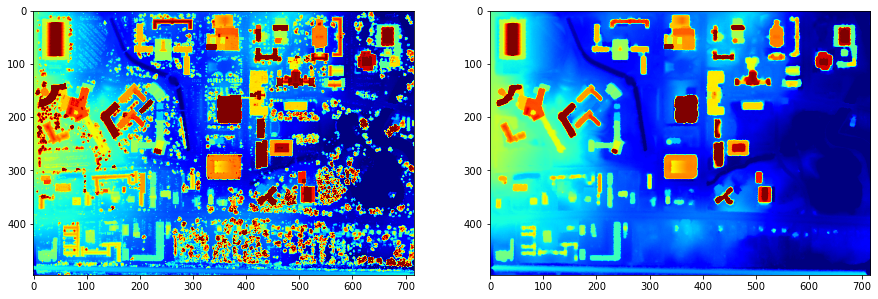

In [3]:
# A basic use case might look like the following:
Zmax, Tmax = smrf.create_dem(x,y,z,cellsize=5,bin_type='max',inpaint=True)

# Use SMRF to filter small objects out of the image
Zsmrf,Tsmrf,obj_cells,obj_array = smrf.smrf(x,y,z,cellsize=5,windows=3,slope_threshold=.15,low_filter_slope=1,
                                           low_outlier_fill=False)

# Save filtered DEM
with rasterio.open('data/dk22_smrfed.tif', 'w', driver='GTiff', 
                             height=Zsmrf.shape[0], width=Zsmrf.shape[1],
                             count=1, dtype=np.float32, transform=Tsmrf) as src:
    src.write(Zsmrf.astype(np.float32), 1)

# Visualize
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(Zmax,aspect='equal',vmin=np.percentile(Zmax,5),vmax=np.percentile(Zmax,95),cmap='jet')
plt.subplot(122)
plt.imshow(Zsmrf,aspect='equal',vmin=np.percentile(Zmax,5),vmax=np.percentile(Zmax,95),cmap='jet')
plt.show()